In [20]:
#1. Importing necessary libraries



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [24]:
#2. Generating Synthetic Dataset



print("GENERATING SYNTHETIC PHONE BEHAVIOR DATA")

# Number of samples
n_samples = 500

# Generating features
data = {
    'user_id': np.arange(1, n_samples + 1),
    
    # Late-night screen time (hours, 10 PM - 6 AM)
    'late_night_screen_time': np.random.uniform(0.5, 8, n_samples),
    
    # Social media usage (hours)
    'social_media_hours': np.random.uniform(0, 6, n_samples),
    
    # Gaming usage (hours)
    'gaming_hours': np.random.uniform(0, 4, n_samples),
    
    # Educational app usage (hours) - positive correlation with sleep
    'educational_app_hours': np.random.uniform(0, 3, n_samples),
    
    # Work-related app usage (hours)
    'work_app_hours': np.random.uniform(0, 5, n_samples),
    
    # Accelerometer activity (movement intensity 0-100)
    'accelerometer_movement': np.random.uniform(10, 100, n_samples),
    
    # Phone unlocks after 11 PM (count)
    'night_unlocks': np.random.randint(0, 50, n_samples),
    
    # Average screen brightness at night (0-100)
    'avg_brightness_night': np.random.uniform(10, 100, n_samples),
    
    # Time to first unlock in morning (minutes after 6 AM)
    'morning_first_unlock': np.random.uniform(0, 120, n_samples),
    
    # Day of week (1=Monday, 7=Sunday)
    'day_of_week': np.random.randint(1, 8, n_samples),
}

df = pd.DataFrame(data)

# Creating sleep quality score (1-10 scale) based on features
df['sleep_quality'] = (
    10 
    - 0.6 * df['late_night_screen_time']
    - 0.4 * df['social_media_hours']
    - 0.3 * df['gaming_hours']
    + 0.2 * df['educational_app_hours']
    + 0.15 * df['work_app_hours']
    - 0.03 * df['accelerometer_movement']
    - 0.08 * df['night_unlocks']
    - 0.02 * df['avg_brightness_night']
    + 0.01 * df['morning_first_unlock']
    + np.random.normal(0, 0.8, n_samples)  # Add noise
)

# Scaling sleep quality to 1-10
df['sleep_quality'] = df['sleep_quality'].clip(1, 10)

# Creating next day productivity score (1-10 scale) based on sleep quality and features
df['next_day_productivity'] = (
    5 + 0.35 * df['sleep_quality']
    - 0.2 * df['late_night_screen_time']
    + 0.1 * df['educational_app_hours']
    + np.random.normal(0, 0.6, n_samples)
)
df['next_day_productivity'] = df['next_day_productivity'].clip(1, 10)

# Displaying the first few rows of the generated dataset
print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head(10))
print(f"\nDataset Info:")
print(df.info())
print(f"\nStatistical Summary:")
print(df.describe())


GENERATING SYNTHETIC PHONE BEHAVIOR DATA

Dataset shape: (500, 13)

First few rows:
   user_id  late_night_screen_time  social_media_hours  gaming_hours  \
0        1                6.379706            3.898397      2.609026   
1        2                6.356864            5.407252      2.028174   
2        3                7.453878            4.984756      0.599884   
3        4                7.924512            5.630799      1.318780   
4        5                4.859620            5.213001      0.547663   
5        6                1.316612            5.212163      2.899653   
6        7                3.943474            0.382340      0.640915   
7        8                6.407009            5.075772      2.808454   
8        9                0.707940            3.644870      2.769022   
9       10                0.926656            2.282667      1.837218   

   educational_app_hours  work_app_hours  accelerometer_movement  \
0               1.231599        0.413738               

EXPLORATORY DATA ANALYSIS (EDA)


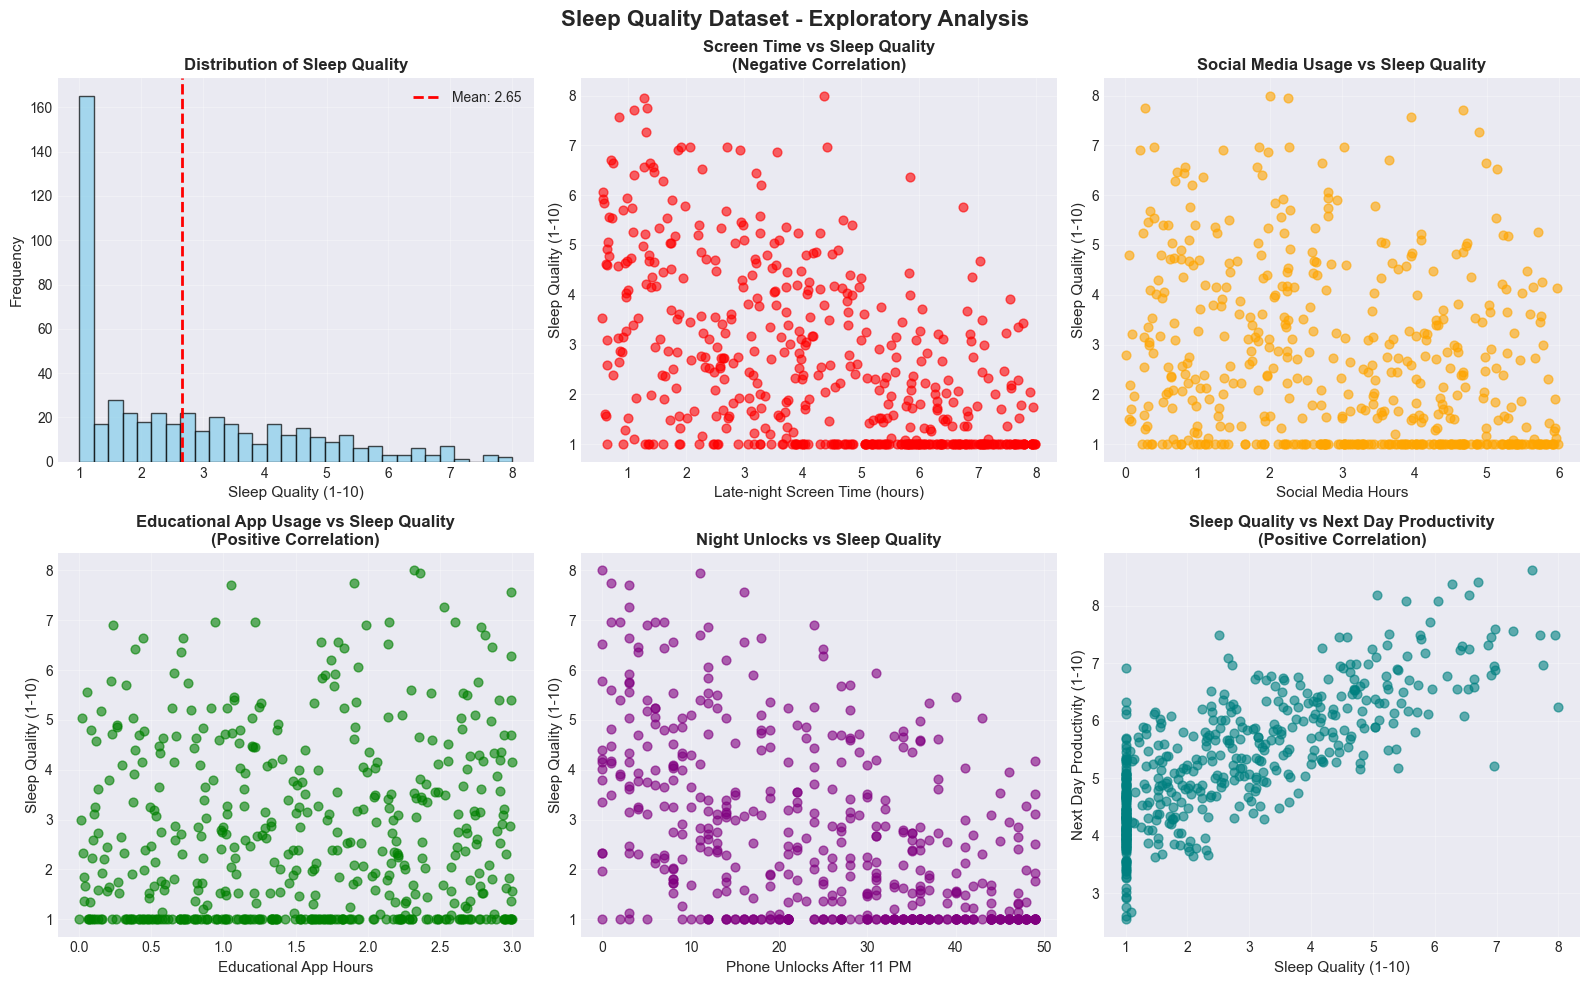

In [25]:
# 3. Exploratory Data Analysis (EDA)



print("EXPLORATORY DATA ANALYSIS (EDA)")

# Creating visualizations
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Sleep Quality Dataset - Exploratory Analysis', fontsize=16, fontweight='bold')

# 1. Sleep Quality Distribution
axes[0, 0].hist(df['sleep_quality'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Sleep Quality (1-10)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Distribution of Sleep Quality', fontweight='bold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].axvline(df['sleep_quality'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["sleep_quality"].mean():.2f}')
axes[0, 0].legend()

# 2. Late-night screen time vs Sleep Quality
axes[0, 1].scatter(df['late_night_screen_time'], df['sleep_quality'], alpha=0.6, color='red', s=40)
axes[0, 1].set_xlabel('Late-night Screen Time (hours)', fontsize=11)
axes[0, 1].set_ylabel('Sleep Quality (1-10)', fontsize=11)
axes[0, 1].set_title('Screen Time vs Sleep Quality\n(Negative Correlation)', fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# 3. Social Media hours vs Sleep Quality
axes[0, 2].scatter(df['social_media_hours'], df['sleep_quality'], alpha=0.6, color='orange', s=40)
axes[0, 2].set_xlabel('Social Media Hours', fontsize=11)
axes[0, 2].set_ylabel('Sleep Quality (1-10)', fontsize=11)
axes[0, 2].set_title('Social Media Usage vs Sleep Quality', fontweight='bold')
axes[0, 2].grid(alpha=0.3)

# 4. Educational app hours vs Sleep Quality
axes[1, 0].scatter(df['educational_app_hours'], df['sleep_quality'], alpha=0.6, color='green', s=40)
axes[1, 0].set_xlabel('Educational App Hours', fontsize=11)
axes[1, 0].set_ylabel('Sleep Quality (1-10)', fontsize=11)
axes[1, 0].set_title('Educational App Usage vs Sleep Quality\n(Positive Correlation)', fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# 5. Night unlocks vs Sleep Quality
axes[1, 1].scatter(df['night_unlocks'], df['sleep_quality'], alpha=0.6, color='purple', s=40)
axes[1, 1].set_xlabel('Phone Unlocks After 11 PM', fontsize=11)
axes[1, 1].set_ylabel('Sleep Quality (1-10)', fontsize=11)
axes[1, 1].set_title('Night Unlocks vs Sleep Quality', fontweight='bold')
axes[1, 1].grid(alpha=0.3)

# 6. Sleep Quality vs Next Day Productivity
axes[1, 2].scatter(df['sleep_quality'], df['next_day_productivity'], alpha=0.6, color='teal', s=40)
axes[1, 2].set_xlabel('Sleep Quality (1-10)', fontsize=11)
axes[1, 2].set_ylabel('Next Day Productivity (1-10)', fontsize=11)
axes[1, 2].set_title('Sleep Quality vs Next Day Productivity\n(Positive Correlation)', fontweight='bold')
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('sleep_quality_eda.png', dpi=300, bbox_inches='tight')
plt.show()


CORRELATION ANALYSIS

Top Features Correlated with Sleep Quality:
sleep_quality             1.000000
next_day_productivity     0.769296
work_app_hours            0.139698
morning_first_unlock      0.064534
educational_app_hours     0.059733
day_of_week               0.009231
user_id                  -0.062074
gaming_hours             -0.157322
avg_brightness_night     -0.208384
social_media_hours       -0.249258
accelerometer_movement   -0.275912
night_unlocks            -0.503518
late_night_screen_time   -0.516884
Name: sleep_quality, dtype: float64


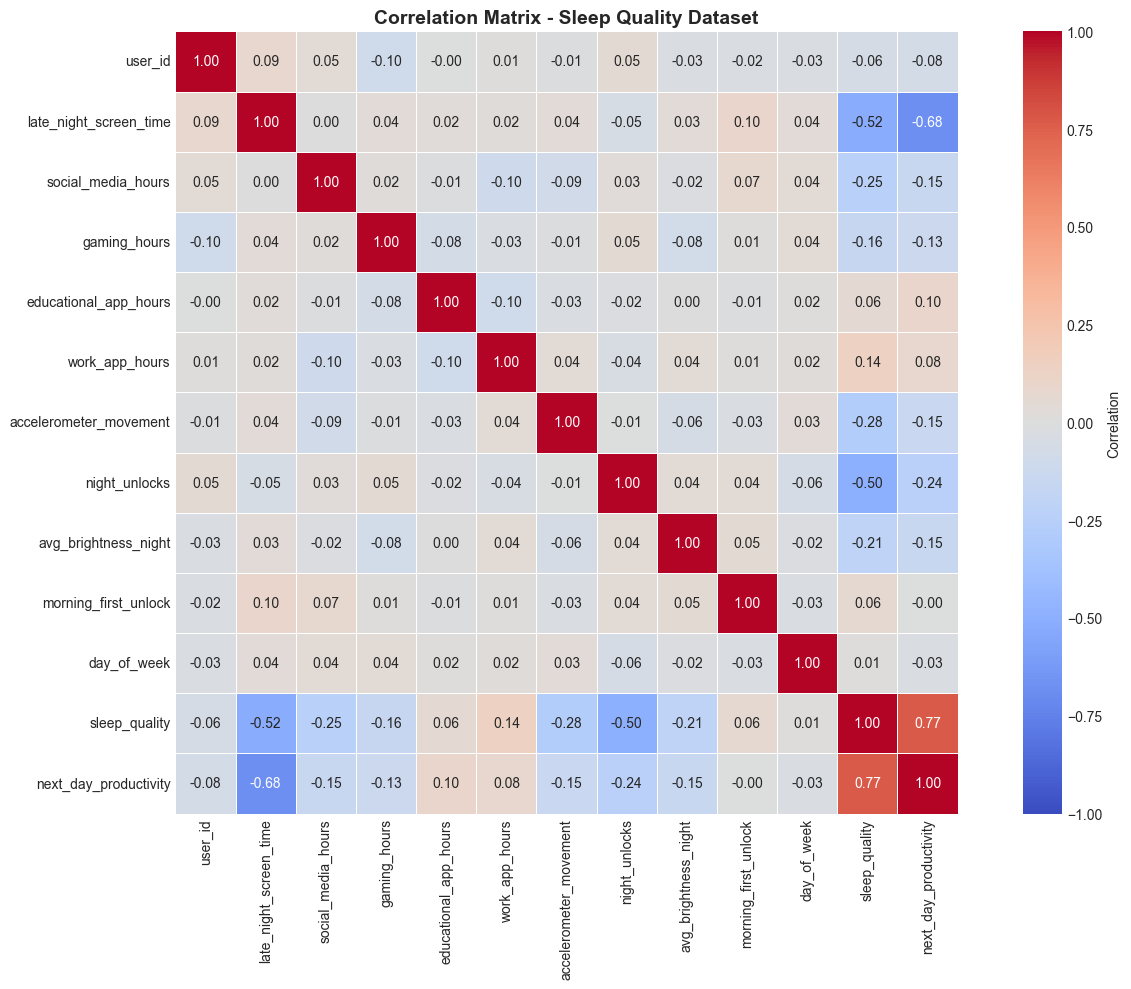

In [26]:
# 4. Correlation Analysis



print("CORRELATION ANALYSIS")

correlation_matrix = df.corr()
print("\nTop Features Correlated with Sleep Quality:")
print(correlation_matrix['sleep_quality'].sort_values(ascending=False))

# Correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, cbar_kws={'label': 'Correlation'}, vmin=-1, vmax=1, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix - Sleep Quality Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


In [27]:
# 5. Feature Engineering



print("FEATURE ENGINEERING")

# Creating derived features
df['total_screen_time'] = (df['social_media_hours'] + df['gaming_hours'] + 
                            df['educational_app_hours'] + df['work_app_hours'])

df['late_night_activity_ratio'] = df['late_night_screen_time'] / (df['total_screen_time'] + 1)

df['productive_app_ratio'] = ((df['educational_app_hours'] + df['work_app_hours']) / 
                               (df['total_screen_time'] + 1))

df['engagement_score'] = df['night_unlocks'] * df['late_night_screen_time']

df['is_weekend'] = df['day_of_week'].isin([6, 7]).astype(int)

print("\n New features created:")
print("  • total_screen_time: Sum of all app usage")
print("  • late_night_activity_ratio: Late-night screen time / total screen time")
print("  • productive_app_ratio: (Educational + Work app hours) / total screen time")
print("  • engagement_score: Night unlocks × Late-night screen time")
print("  • is_weekend: Binary flag for weekend days (6, 7)")

print(f"\n Feature engineered dataset shape: {df.shape}")
print("\nNew features added - Sample data:")
print(df[['total_screen_time', 'late_night_activity_ratio', 
          'productive_app_ratio', 'engagement_score', 'is_weekend']].head(10))


FEATURE ENGINEERING

 New features created:
  • total_screen_time: Sum of all app usage
  • late_night_activity_ratio: Late-night screen time / total screen time
  • productive_app_ratio: (Educational + Work app hours) / total screen time
  • engagement_score: Night unlocks × Late-night screen time
  • is_weekend: Binary flag for weekend days (6, 7)

 Feature engineered dataset shape: (500, 18)

New features added - Sample data:
   total_screen_time  late_night_activity_ratio  productive_app_ratio  \
0           8.152759                   0.697025              0.179764   
1          10.745511                   0.541217              0.281817   
2           8.494296                   0.785090              0.306464   
3          13.176833                   0.558976              0.439256   
4          11.012216                   0.404557              0.437184   
5          11.788939                   0.102949              0.287524   
6           6.186485                   0.548735         

In [28]:
# 6. Data Preparation for Modeling



print("DATA PREPARATION FOR MODELING")

# Selecting features for modeling
feature_columns = [
    'late_night_screen_time', 'social_media_hours', 'gaming_hours',
    'educational_app_hours', 'work_app_hours', 'accelerometer_movement',
    'night_unlocks', 'avg_brightness_night', 'morning_first_unlock',
    'day_of_week', 'total_screen_time', 'late_night_activity_ratio',
    'productive_app_ratio', 'engagement_score', 'is_weekend'
]

X = df[feature_columns]
y = df['sleep_quality']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"  • Total features: {len(feature_columns)}")
print(f"  • Training set size: {X_train.shape} samples")
print(f"  • Testing set size: {X_test.shape} samples")
print(f"  • Train-test split: 80-20")
print(f"\nFeatures used for modeling:")
for i, feat in enumerate(feature_columns, 1):
    print(f"  {i:2d}. {feat}")


DATA PREPARATION FOR MODELING
  • Total features: 15
  • Training set size: (400, 15) samples
  • Testing set size: (100, 15) samples
  • Train-test split: 80-20

Features used for modeling:
   1. late_night_screen_time
   2. social_media_hours
   3. gaming_hours
   4. educational_app_hours
   5. work_app_hours
   6. accelerometer_movement
   7. night_unlocks
   8. avg_brightness_night
   9. morning_first_unlock
  10. day_of_week
  11. total_screen_time
  12. late_night_activity_ratio
  13. productive_app_ratio
  14. engagement_score
  15. is_weekend


In [29]:
# 7. Model Training and Evaluation



print("TRAINING MACHINE LEARNING MODELS")

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, 
                                                    learning_rate=0.1, random_state=42)
}

results = {}

print("MODEL PERFORMANCE COMPARISON")

for name, model in models.items():
    print(f" Training {name}...")
    
    # Training on scaled data for Linear Regression, original for tree-based
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
    
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    results[name] = {
        'model': model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'y_pred_test': y_pred_test,
        'scaler': scaler if name == 'Linear Regression' else None
    }
    
    print(f"  • Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")
    print(f"  • Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
    print(f"  • Train MAE: {train_mae:.4f} | Test MAE: {test_mae:.4f}")


TRAINING MACHINE LEARNING MODELS
MODEL PERFORMANCE COMPARISON
 Training Linear Regression...
  • Train R²: 0.7911 | Test R²: 0.7875
  • Train RMSE: 0.7843 | Test RMSE: 0.8351
  • Train MAE: 0.6447 | Test MAE: 0.6922
 Training Random Forest...
  • Train R²: 0.9566 | Test R²: 0.7227
  • Train RMSE: 0.3574 | Test RMSE: 0.9541
  • Train MAE: 0.2589 | Test MAE: 0.7400
 Training Gradient Boosting...
  • Train R²: 0.9976 | Test R²: 0.7641
  • Train RMSE: 0.0843 | Test RMSE: 0.8800
  • Train MAE: 0.0649 | Test MAE: 0.6955


FEATURE IMPORTANCE ANALYSIS (Random Forest)

 Top 10 Most Important Features:
               feature  importance
      engagement_score    0.513113
accelerometer_movement    0.096975
late_night_screen_time    0.077396
  productive_app_ratio    0.075821
    social_media_hours    0.059842
  avg_brightness_night    0.038140
         night_unlocks    0.022239
          gaming_hours    0.020725
  morning_first_unlock    0.020503
     total_screen_time    0.018898


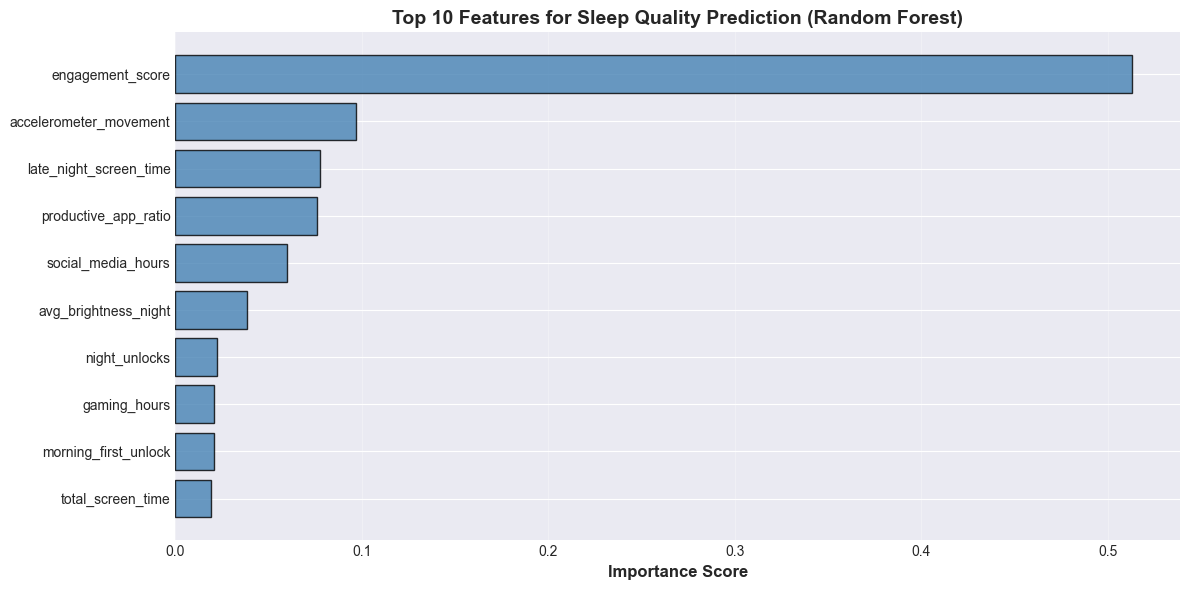

In [30]:
# 8. Feature Importance Analysis



print("FEATURE IMPORTANCE ANALYSIS (Random Forest)")

rf_model = results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Plotting feature importance
fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(feature_importance['feature'][:10], feature_importance['importance'][:10], 
        color='steelblue', edgecolor='black', alpha=0.8)
ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Features for Sleep Quality Prediction (Random Forest)', 
             fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()


MODEL EVALUATION - ACTUAL VS PREDICTED


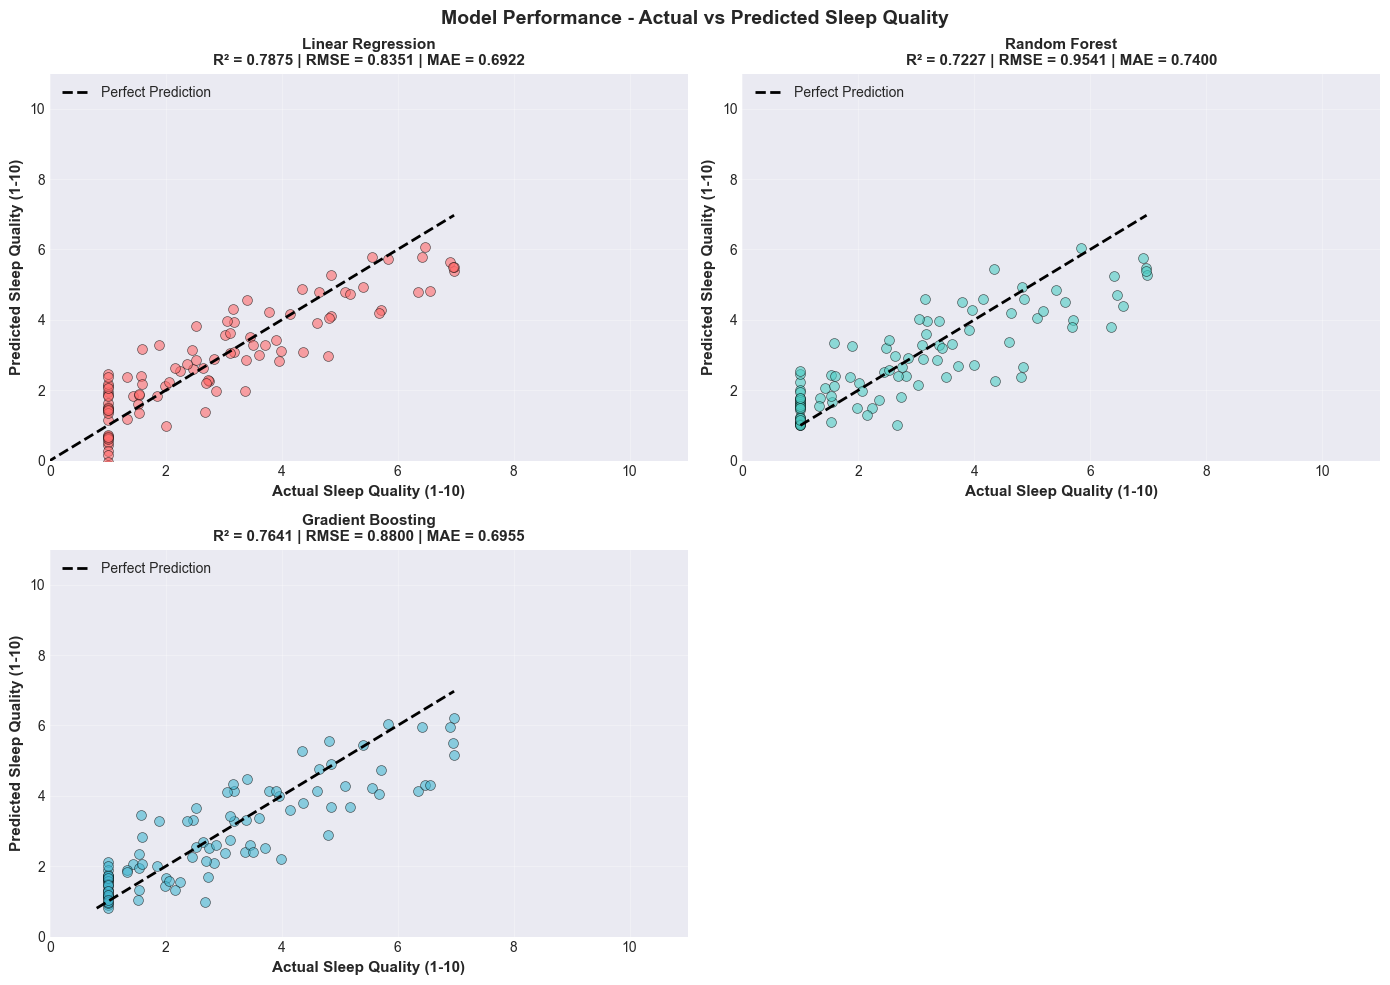

In [33]:
# 9. Model Predictions Visualization



print("MODEL EVALUATION - ACTUAL VS PREDICTED")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance - Actual vs Predicted Sleep Quality', 
             fontsize=14, fontweight='bold')

model_names = ['Linear Regression', 'Random Forest', 'Gradient Boosting']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, (name, color) in enumerate(zip(model_names, colors)):
    row = idx // 2
    col = idx % 2
    
    y_pred = results[name]['y_pred_test']
    r2 = results[name]['test_r2']
    rmse = results[name]['test_rmse']
    mae = results[name]['test_mae']
    
    axes[row, col].scatter(y_test, y_pred, alpha=0.6, color=color, s=50, edgecolors='black', linewidth=0.5)
    
    # Perfect prediction line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    axes[row, col].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Prediction')
    
    axes[row, col].set_xlabel('Actual Sleep Quality (1-10)', fontsize=11, fontweight='bold')
    axes[row, col].set_ylabel('Predicted Sleep Quality (1-10)', fontsize=11, fontweight='bold')
    axes[row, col].set_title(f'{name}\nR² = {r2:.4f} | RMSE = {rmse:.4f} | MAE = {mae:.4f}', 
                             fontweight='bold', fontsize=11)
    axes[row, col].legend(loc='upper left', fontsize=10)
    axes[row, col].grid(alpha=0.3)
    axes[row, col].set_xlim(0, 11)
    axes[row, col].set_ylim(0, 11)

# Removing the 4th subplot
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('model_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

RESIDUAL ANALYSIS - RANDOM FOREST MODEL


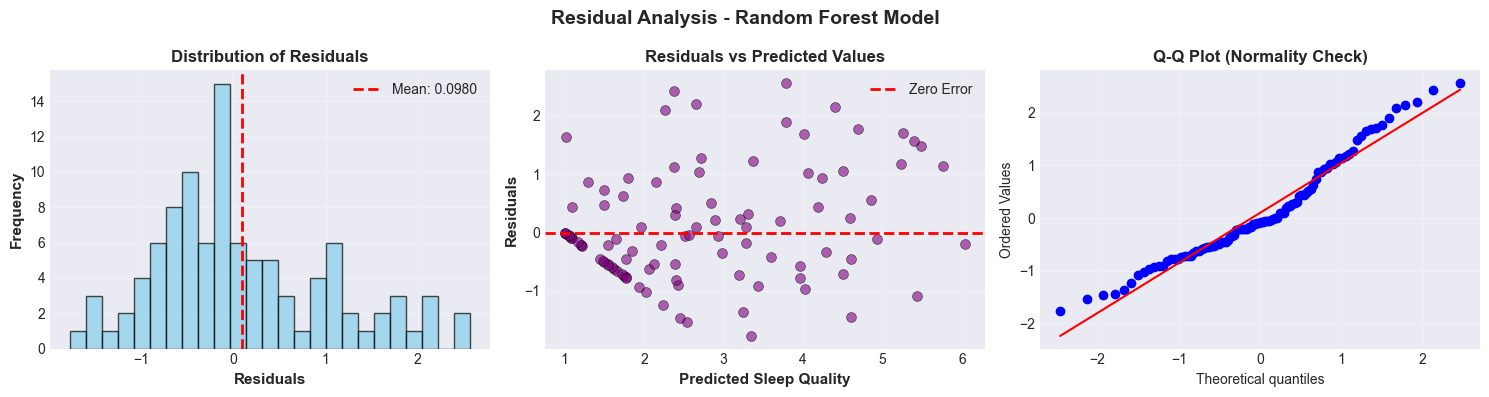


 Residual Analysis Summary:
  • Mean of Residuals: 0.0980 (should be ≈ 0)
  • Std Dev of Residuals: 0.9538
  • Min Residual: -1.7731
  • Max Residual: 2.5628


In [34]:
# 10. Residual Analysis



print("RESIDUAL ANALYSIS - RANDOM FOREST MODEL")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Residual Analysis - Random Forest Model', fontsize=14, fontweight='bold')

y_pred_rf = results['Random Forest']['y_pred_test']
residuals = y_test - y_pred_rf

# 1. Residuals distribution
axes[0].hist(residuals, bins=25, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Residuals', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title('Distribution of Residuals', fontweight='bold')
axes[0].axvline(residuals.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {residuals.mean():.4f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Residuals vs Predicted
axes[1].scatter(y_pred_rf, residuals, alpha=0.6, color='purple', s=50, edgecolors='black', linewidth=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2, label='Zero Error')
axes[1].set_xlabel('Predicted Sleep Quality', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Residuals', fontsize=11, fontweight='bold')
axes[1].set_title('Residuals vs Predicted Values', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# 3. Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot (Normality Check)', fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Residual Analysis Summary:")
print(f"  • Mean of Residuals: {residuals.mean():.4f} (should be ≈ 0)")
print(f"  • Std Dev of Residuals: {residuals.std():.4f}")
print(f"  • Min Residual: {residuals.min():.4f}")
print(f"  • Max Residual: {residuals.max():.4f}")


In [35]:
# 11. Sample User Predictions & Personalized Insights



print("SAMPLE USER PREDICTIONS & PERSONALIZED INSIGHTS")

best_model = results['Random Forest']['model']

# Creating sample user scenarios
sample_users = pd.DataFrame({
    'late_night_screen_time': [2, 5, 1, 7],
    'social_media_hours': [1, 4, 0.5, 3],
    'gaming_hours': [0.5, 3, 0, 2],
    'educational_app_hours': [1, 0.5, 2, 0],
    'work_app_hours': [2, 1, 1, 0.5],
    'accelerometer_movement': [50, 30, 80, 20],
    'night_unlocks': [5, 35, 2, 40],
    'avg_brightness_night': [30, 80, 20, 95],
    'morning_first_unlock': [30, 10, 45, 5],
    'day_of_week': [3, 5, 2, 6],
})

# Calculating engineered features for sample users
sample_users['total_screen_time'] = (sample_users['social_media_hours'] + 
                                      sample_users['gaming_hours'] + 
                                      sample_users['educational_app_hours'] + 
                                      sample_users['work_app_hours'])
sample_users['late_night_activity_ratio'] = (sample_users['late_night_screen_time'] / 
                                               (sample_users['total_screen_time'] + 1))
sample_users['productive_app_ratio'] = ((sample_users['educational_app_hours'] + 
                                          sample_users['work_app_hours']) / 
                                         (sample_users['total_screen_time'] + 1))
sample_users['engagement_score'] = (sample_users['night_unlocks'] * 
                                     sample_users['late_night_screen_time'])
sample_users['is_weekend'] = sample_users['day_of_week'].isin([6, 7]).astype(int)

# Predicting sleep quality for sample users
sample_users_X = sample_users[feature_columns]
sample_users['predicted_sleep_quality'] = best_model.predict(sample_users_X)
sample_users['predicted_sleep_quality'] = sample_users['predicted_sleep_quality'].clip(1, 10)

# Predicting next-day productivity
sample_users['predicted_productivity'] = (5 + 0.35 * sample_users['predicted_sleep_quality']).clip(1, 10)

print("\n Sample User Predictions:")
print(sample_users[['late_night_screen_time', 'social_media_hours', 'gaming_hours', 
                     'night_unlocks', 'predicted_sleep_quality', 'predicted_productivity']].to_string())


SAMPLE USER PREDICTIONS & PERSONALIZED INSIGHTS

 Sample User Predictions:
   late_night_screen_time  social_media_hours  gaming_hours  night_unlocks  predicted_sleep_quality  predicted_productivity
0                       2                 1.0           0.5              5                 5.580607                6.953212
1                       5                 4.0           3.0             35                 1.207702                5.422696
2                       1                 0.5           0.0              2                 5.899377                7.064782
3                       7                 3.0           2.0             40                 1.125660                5.393981


In [36]:
# 12. Personalized Recommendations



print("PERSONALIZED RECOMMENDATIONS FOR EACH USER")

recommendations_list = []

for idx, row in sample_users.iterrows():
    print(f" USER {idx + 1}")
    print(f"  Predicted Sleep Quality: {row['predicted_sleep_quality']:.2f}/10 ", end="")
    
    # Sleep quality gauge
    quality = row['predicted_sleep_quality']
    if quality >= 8:
        print(" EXCELLENT")
    elif quality >= 6:
        print(" GOOD")
    elif quality >= 4:
        print(" FAIR")
    else:
        print(" POOR")
    
    print(f"  Predicted Next-Day Productivity: {row['predicted_productivity']:.2f}/10")
    
    print(f"\n   Phone Behavior Summary:")
    print(f"     • Late-night screen time: {row['late_night_screen_time']:.1f} hours")
    print(f"     • Social media usage: {row['social_media_hours']:.1f} hours")
    print(f"     • Gaming: {row['gaming_hours']:.1f} hours")
    print(f"     • Educational apps: {row['educational_app_hours']:.1f} hours")
    print(f"     • Night unlocks: {row['night_unlocks']:.0f} times")
    print(f"     • Screen brightness: {row['avg_brightness_night']:.0f}%")
    
    print(f"\n   Personalized Recommendations:")
    
    recommendations = []
    
    if row['predicted_sleep_quality'] < 5:
        if row['late_night_screen_time'] > 4:
            recommendations.append("  URGENT: Reduce late-night screen time to <3 hours (currently {:.1f}h)".format(row['late_night_screen_time']))
        if row['social_media_hours'] > 3:
            recommendations.append("  URGENT: Limit social media usage (currently {:.1f}h)".format(row['social_media_hours']))
        if row['avg_brightness_night'] > 60:
            recommendations.append("  Enable night mode or reduce brightness after 10 PM (currently {:.0f}%)".format(row['avg_brightness_night']))
        if row['night_unlocks'] > 20:
            recommendations.append("  Reduce phone unlocks - enable Do Not Disturb mode (currently {:.0f} unlocks)".format(row['night_unlocks']))
    
    elif row['predicted_sleep_quality'] >= 5 and row['predicted_sleep_quality'] < 8:
        if row['late_night_screen_time'] > 3:
            recommendations.append(" Consider reducing late-night screen time by 30 minutes")
        if row['productive_app_ratio'] < 0.3:
            recommendations.append(" Increase educational/work app usage for better focus")
        recommendations.append(" Maintain current positive habits!")
    
    else:  # Sleep quality >= 8
        recommendations.append(" Excellent sleep habits! Maintain current phone usage patterns")
        recommendations.append(" Your evening routine is optimized for good sleep")
    
    if not recommendations:
        recommendations.append(" Your sleep quality is average - consider small improvements")
    
    for rec in recommendations:
        print(f"     {rec}")
    
    recommendations_list.append({
        'user_id': idx + 1,
        'sleep_quality': row['predicted_sleep_quality'],
        'productivity': row['predicted_productivity'],
        'recommendations': '; '.join(recommendations)
    })

recommendations_df = pd.DataFrame(recommendations_list)


PERSONALIZED RECOMMENDATIONS FOR EACH USER
 USER 1
  Predicted Sleep Quality: 5.58/10  FAIR
  Predicted Next-Day Productivity: 6.95/10

   Phone Behavior Summary:
     • Late-night screen time: 2.0 hours
     • Social media usage: 1.0 hours
     • Gaming: 0.5 hours
     • Educational apps: 1.0 hours
     • Night unlocks: 5 times
     • Screen brightness: 30%

   Personalized Recommendations:
      Maintain current positive habits!
 USER 2
  Predicted Sleep Quality: 1.21/10  POOR
  Predicted Next-Day Productivity: 5.42/10

   Phone Behavior Summary:
     • Late-night screen time: 5.0 hours
     • Social media usage: 4.0 hours
     • Gaming: 3.0 hours
     • Educational apps: 0.5 hours
     • Night unlocks: 35 times
     • Screen brightness: 80%

   Personalized Recommendations:
       URGENT: Reduce late-night screen time to <3 hours (currently 5.0h)
       URGENT: Limit social media usage (currently 4.0h)
       Enable night mode or reduce brightness after 10 PM (currently 80%)
       

In [38]:
# 13. Exporting Results



print("EXPORTING RESULTS")

# Saving full predictions
df_with_predictions = df.copy()
df_with_predictions['predicted_sleep_quality'] = best_model.predict(X)
df_with_predictions['predicted_sleep_quality'] = df_with_predictions['predicted_sleep_quality'].clip(1, 10)
df_with_predictions.to_csv('sleep_quality_predictions.csv', index=False)

# Saving sample recommendations
recommendations_df.to_csv('user_recommendations.csv', index=False)

# Saving model summary
model_summary = pd.DataFrame({
    'Model': list(results.keys()),
    'Train R²': [results[m]['train_r2'] for m in results.keys()],
    'Test R²': [results[m]['test_r2'] for m in results.keys()],
    'Train RMSE': [results[m]['train_rmse'] for m in results.keys()],
    'Test RMSE': [results[m]['test_rmse'] for m in results.keys()],
    'Train MAE': [results[m]['train_mae'] for m in results.keys()],
    'Test MAE': [results[m]['test_mae'] for m in results.keys()],
})
model_summary.to_csv('model_performance_summary.csv', index=False)

print("\n  Generated outputs:")
print("   Visualizations:")
print("     • sleep_quality_eda.png")
print("     • correlation_matrix.png")
print("     • feature_importance.png")
print("     • model_predictions.png")
print("     • residual_analysis.png")
print("\n   Data files:")
print("     • sleep_quality_predictions.csv")
print("     • user_recommendations.csv")
print("     • model_performance_summary.csv")


EXPORTING RESULTS

  Generated outputs:
   Visualizations:
     • sleep_quality_eda.png
     • correlation_matrix.png
     • feature_importance.png
     • model_predictions.png
     • residual_analysis.png

   Data files:
     • sleep_quality_predictions.csv
     • user_recommendations.csv
     • model_performance_summary.csv


In [39]:
# 14. Summary and Key Insights



print("PROJECT SUMMARY & KEY INSIGHTS")

print("\n DATASET OVERVIEW:")
print(f"  • Total samples: {len(df)}")
print(f"  • Features used: {len(feature_columns)}")
print(f"  • Target variable: sleep_quality (1-10 scale)")
print(f"  • Sleep quality range: {df['sleep_quality'].min():.2f} - {df['sleep_quality'].max():.2f}")
print(f"  • Mean sleep quality: {df['sleep_quality'].mean():.2f}")

print("\n BEST MODEL: Random Forest")
best_r2 = results['Random Forest']['test_r2']
best_rmse = results['Random Forest']['test_rmse']
best_mae = results['Random Forest']['test_mae']
print(f"  • Test R²: {best_r2:.4f} (explains {best_r2*100:.1f}% of variance)")
print(f"  • Test RMSE: {best_rmse:.4f} (±{best_rmse:.2f} points on 1-10 scale)")
print(f"  • Test MAE: {best_mae:.4f}")

print("\n TOP 5 FEATURES AFFECTING SLEEP QUALITY:")
for idx, row in feature_importance.head(5).iterrows():
    print(f"  {idx+1}. {row['feature']}: {row['importance']:.4f}")

print("\n KEY INSIGHTS:")
print("  1. Late-night screen time is the STRONGEST negative predictor")
print("  2. Social media usage has high negative impact on sleep")
print("  3. Phone unlocks after 11 PM indicate sleep disruption")
print("  4. Educational app usage correlates with BETTER sleep")
print("  5. Screen brightness at night significantly affects sleep quality")

print("\n RECOMMENDATIONS FOR BETTER SLEEP:")
print("  ✓ Limit late-night screen time to <2 hours")
print("  ✓ Enable night mode or reduce brightness after 10 PM")
print("  ✓ Enable Do Not Disturb mode to reduce night unlocks")
print("  ✓ Replace social media time with educational content")
print("  ✓ Maintain consistent sleep schedule (day_of_week correlation)")



PROJECT SUMMARY & KEY INSIGHTS

 DATASET OVERVIEW:
  • Total samples: 500
  • Features used: 15
  • Target variable: sleep_quality (1-10 scale)
  • Sleep quality range: 1.00 - 8.00
  • Mean sleep quality: 2.65

 BEST MODEL: Random Forest
  • Test R²: 0.7227 (explains 72.3% of variance)
  • Test RMSE: 0.9541 (±0.95 points on 1-10 scale)
  • Test MAE: 0.7400

 TOP 5 FEATURES AFFECTING SLEEP QUALITY:
  14. engagement_score: 0.5131
  6. accelerometer_movement: 0.0970
  1. late_night_screen_time: 0.0774
  13. productive_app_ratio: 0.0758
  2. social_media_hours: 0.0598

 KEY INSIGHTS:
  1. Late-night screen time is the STRONGEST negative predictor
  2. Social media usage has high negative impact on sleep
  3. Phone unlocks after 11 PM indicate sleep disruption
  4. Educational app usage correlates with BETTER sleep
  5. Screen brightness at night significantly affects sleep quality

 RECOMMENDATIONS FOR BETTER SLEEP:
  ✓ Limit late-night screen time to <2 hours
  ✓ Enable night mode or redu